In [1]:
import scipy
import utils.preprocess as preprocess
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import solvers.pdas as pdas
import solvers.wpdas as wpdas
import solvers.ipm as ipm
from timeit import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Load Data
stim = scipy.io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [3]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [4]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

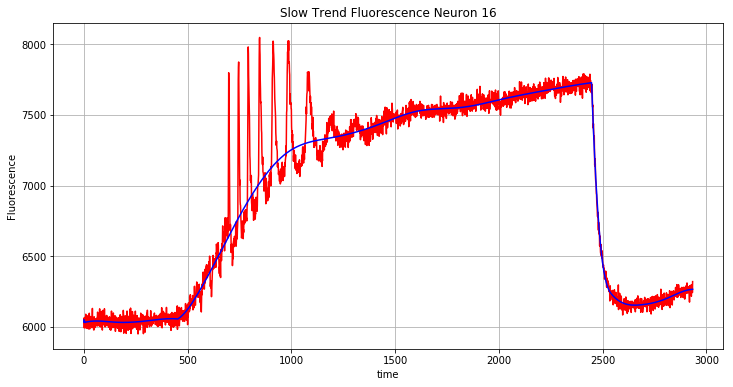

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [6]:
import utils.noise
import numpy.random

In [7]:
def solve_constrained_c(y, step_heuristic=60, maxiter=2000, verbose=0, tol=1e-3):
    
    # Init plotting vars
    lams = []
    mses = []
    iters = []
    tols = []
    
    # estimate noise levels and scale
    noise_std = utils.noise.estimate_noise([y], summarize="mean")[0]
    delta = noise_std ** 2  # constraint to satisfy
    scale = delta / np.sqrt(np.mean(np.power(y, 2) - delta)) # assuming centered
    
    # Compute first search point and step size
    int_min = np.log(3*scale + 1)
    int_width = np.log(20+(1/scale)) - np.log(3+(1/scale))
    lam = np.exp(int_width / 2 + int_min) - 1
    lams.append(lam)
    tau_int =  int_width / step_heuristic
    
    # Compute initial solution
    x_hat, z_hat, first_iters = pdas.solve(y, lam, maxiter, verbose)
    extra_iters = 0
    iters.append(extra_iters + first_iters)
    mse = np.mean(np.power(y - x_hat,2))
    mses.append(mse)
    tols.append(np.abs(delta - mse)/delta)
    direction = np.sign(delta - mse)
    
    if direction != 0 and tols[-1] > tol:
        # Take step to compute slope in transformed space
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
        
        # Interpolate in transformed space
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
        direction = np.sign(delta - mse)

   # Compare iterating until we step across delta
    while (direction * np.sign(delta - mse) > 0 and tols[-1] > tol):
        lam = np.exp(np.log(lam + 1) + direction * tau_int) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse_prev = mse
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)

    
    if direction != 0 and tols[-1] > tol:
        # Interpolate for final fit
        slope = direction * (mse - mse_prev) / tau_int
        tau_interp = (delta - mse) / slope
        lam = np.exp(np.log(lam + 1) + tau_interp) - 1
        lams.append(lam)
        x_hat, z_hat, iter_ = pdas.warm_start(y, lam, z_hat, maxiter, verbose)
        mse = np.mean(np.power(y - x_hat,2))
        mses.append(mse)
        tols.append(np.abs(delta - mse)/delta)
        extra_iters += iter_
        iters.append(extra_iters + first_iters)
    
    # return final computed solution
    return x_hat, z_hat, lams, mses, iters, tols, delta

In [222]:
idx = np.random.randint(0, N)
raw = signals[idx,:]
#jdx = np.random.randint(0, N)
#kdx = np.random.randint(0, N)
#raw = np.flip(signals[idx,:], axis=0) + 2 * signals[jdx,:] + signals[kdx,:]
#raw = np.append(raw, np.flip(raw, axis=0)*-1)
#raw = raw + 1000*np.cos(np.arange(len(raw))*.00051)
#raw = raw + np.arange(len(raw))*.5

In [278]:
noise_factor = 8
raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(raw)) + raw

In [279]:
x_hat, z_hat, lams, _, _, _, _ = solve_constrained_c(signal, step_heuristic=75, verbose=1)
mad = np.median(np.abs(x_hat) - np.median(x_hat))

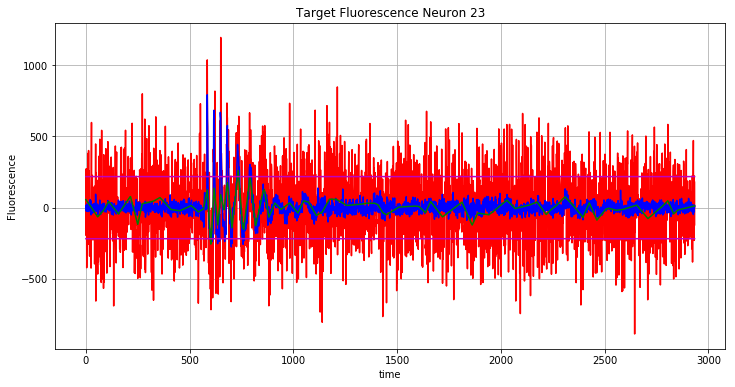

In [280]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [281]:
# upweight spikes
wi = np.ones(len(signal))*.5
# refit
x_hat, z_hat, iters = wpdas.warm_start(signal, wi, lams[-1], z_hat, 2000, 1)
mad = np.median(np.abs(x_hat) - np.median(x_hat))

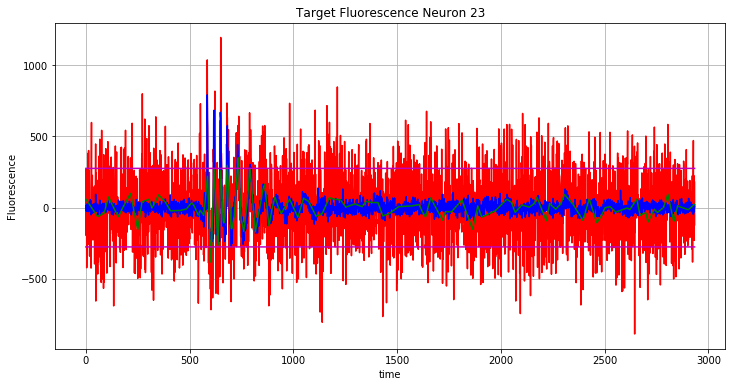

In [282]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [283]:
# threshold to identify spikes
thresh = 9 * mad
# upweight spikes
wi = np.ones(len(signal))
wi[550:800] = .25
# refit
x_hat, z_hat, iters = wpdas.warm_start(signal, wi, lams[-1], z_hat, 2000, 1)
mad = np.median(np.abs(x_hat) - np.median(x_hat))

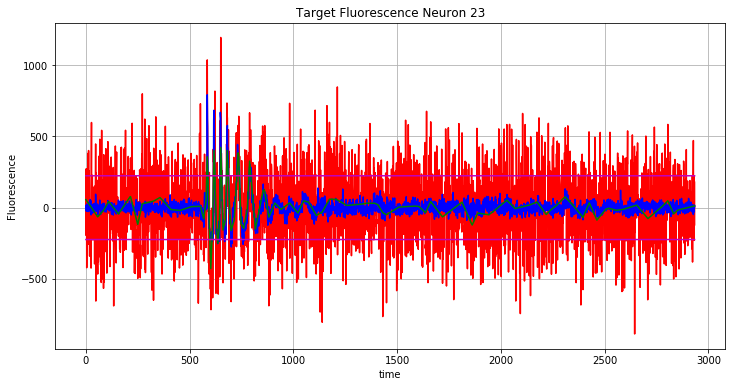

In [284]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [287]:
# threshold to identify spikes
thresh = 9 * mad
# upweight spikes
wi = np.ones(len(signal))*2
#wi[700:1100] = .01
wi[np.array(x_hat) > thresh] = .1
wi[np.array(x_hat) < -thresh] = 1
# refit
x_hat, z_hat, iters = wpdas.warm_start(signal, wi, lams[-1], z_hat, 2000, 1)
mad = np.median(np.abs(x_hat) - np.median(x_hat))

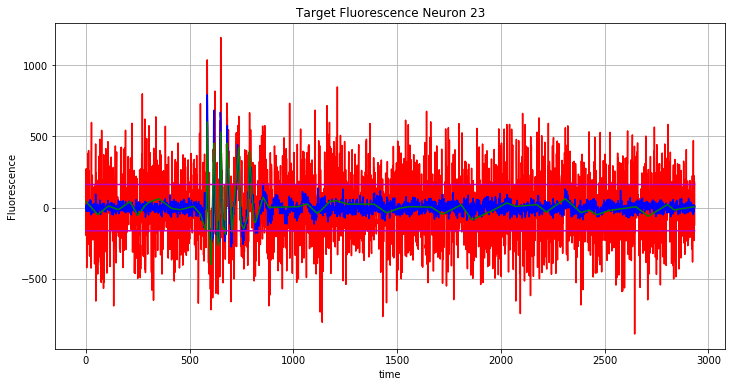

In [288]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

1. Run with loosened noise levels and threshold to detect active regions
2. Run again with upweighted spiking regions (target noise level) (still targeting same lambda)
3. Threshold results and further uweight just the spikes, downweight the rest slightly
4. Final fit.